In [ ]:
!pip install tensorflow==2.16.1 keras numpy opencv-python matplotlib scikit-learn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.6 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of opencv-python to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.9/589.9 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 50.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 38.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 52.1 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      Successfully uninstalled protobuf-5.29.5
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalle

In [ ]:
!pip install -U ml_dtypes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 117.2 MB/s eta 0:00:00
  Attempting uninstall: ml_dtypes
    Found existing installation: ml-dtypes 0.3.2
    Uninstalling ml-dtypes-0.3.2:
      Successfully uninstalled ml-dtypes-0.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.16.1 requires ml-dtypes~=0.3.1, but you have ml-dtypes 0.5.3 which is incompatible.
tf-keras 2.19.0 requires tensorflow<2.20,>=2.19, but you have tensorflow 2.16.1 which is incompatible.
jax 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
tensorflow-decision-forests 1.12.0 requires tensorflow==2.19.0, but you have tensorflow 2.16.1 which is incompatible.
jaxlib 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
tensorflow-text 2.19.0 requires tensorflow<2.20,>=2.19.0, but you have tensorflow 2.16.1 which is inco

In [2]:
# !rm -r data/
# !rm dataset-resized.zip
!unzip -q org-dataset-resized.zip -d data

In [3]:

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np

In [4]:
train_dir = 'data/dataset-resized'

In [8]:

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=0.2
)

train_gen = train_datagen.flow_from_directory(
    'data/dataset-resized',       # ✅ Make sure this path exists and has subfolders per class
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_gen = train_datagen.flow_from_directory(
    'data/dataset-resized',       # ✅ Same folder, using validation subset
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 2024 images belonging to 6 classes.
Found 503 images belonging to 6 classes.


### Data Preparation

In [10]:
base = tf.keras.applications.MobileNetV2(
    input_shape=(128, 128, 3),
    include_top=False,
    weights='imagenet'
)

# Unfreeze more layers for better discriminative learning
for layer in base.layers[:100]:
    layer.trainable = False
for layer in base.layers[100:]:
    layer.trainable = True

model = tf.keras.Sequential([
    base,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(6, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6
)
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history_finetune = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=40,
    callbacks=[callback, early_stop]
)

Epoch 1/40
64/64 ━━━━━━━━━━━━━━━━━━━━ 81s 752ms/step - accuracy: 0.1988 - loss: 2.5532 - val_accuracy: 0.2604 - val_loss: 1.9435 - learning_rate: 3.0000e-05
Epoch 2/40
64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 212ms/step - accuracy: 0.3620 - loss: 1.8546 - val_accuracy: 0.4135 - val_loss: 1.5368 - learning_rate: 3.0000e-05
Epoch 3/40
64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 220ms/step - accuracy: 0.5004 - loss: 1.4293 - val_accuracy: 0.5189 - val_loss: 1.4160 - learning_rate: 3.0000e-05
Epoch 4/40
64/64 ━━━━━━━━━━━━━━━━━━━━ 16s 237ms/step - accuracy: 0.5792 - loss: 1.1867 - val_accuracy: 0.5427 - val_loss: 1.3926 - learning_rate: 3.0000e-05
Epoch 5/40
64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 216ms/step - accuracy: 0.6369 - loss: 1.0926 - val_accuracy: 0.5427 - val_loss: 1.3718 - learning_rate: 3.0000e-05
Epoch 6/40
64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 216ms/step - accuracy: 0.6718 - loss: 0.9172 - val_accuracy: 0.5606 - val_loss: 1.3467 - learning_rate: 3.0000e-05
Epoch 7/40
64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 214ms/step - acc

In [11]:
history_finetune = model.fit(train_gen, validation_data=val_gen, epochs=15)

Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 222ms/step - accuracy: 0.8830 - loss: 0.3315 - val_accuracy: 0.7316 - val_loss: 0.8639
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 214ms/step - accuracy: 0.8816 - loss: 0.3429 - val_accuracy: 0.7177 - val_loss: 0.9020
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 214ms/step - accuracy: 0.9000 - loss: 0.2809 - val_accuracy: 0.7296 - val_loss: 0.8290
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 216ms/step - accuracy: 0.9003 - loss: 0.2853 - val_accuracy: 0.7336 - val_loss: 0.8540
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 16s 258ms/step - accuracy: 0.9112 - loss: 0.2768 - val_accuracy: 0.7276 - val_loss: 0.8128
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 216ms/step - accuracy: 0.9089 - loss: 0.2648 - val_accuracy: 0.7217 - val_loss: 0.8501
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 213ms/step - accuracy: 0.8903 - loss: 0.2895 - val_accuracy: 0.7594 - val_loss: 0.8172
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 212ms/step - accuracy: 0.8993 - loss: 0.2651 - val_accu

In [12]:
history_finetune = model.fit(train_gen, validation_data=val_gen, epochs=20)

Epoch 1/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 16s 240ms/step - accuracy: 0.9323 - loss: 0.1838 - val_accuracy: 0.7475 - val_loss: 0.8206
Epoch 2/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 217ms/step - accuracy: 0.9244 - loss: 0.2169 - val_accuracy: 0.7336 - val_loss: 0.8500
Epoch 3/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 210ms/step - accuracy: 0.9287 - loss: 0.2068 - val_accuracy: 0.7376 - val_loss: 0.7808
Epoch 4/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 211ms/step - accuracy: 0.9325 - loss: 0.1890 - val_accuracy: 0.7495 - val_loss: 0.7485
Epoch 5/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 212ms/step - accuracy: 0.9318 - loss: 0.1927 - val_accuracy: 0.7455 - val_loss: 0.7940
Epoch 6/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 216ms/step - accuracy: 0.9370 - loss: 0.1797 - val_accuracy: 0.7694 - val_loss: 0.7500
Epoch 7/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 213ms/step - accuracy: 0.9351 - loss: 0.1887 - val_accuracy: 0.7694 - val_loss: 0.7383
Epoch 8/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 15s 237ms/step - accuracy: 0.9440 - loss: 0.1698 - val_accu

In [14]:
history_finetune = model.fit(train_gen, validation_data=val_gen, epochs=25)

Epoch 1/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 17s 267ms/step - accuracy: 0.9575 - loss: 0.1389 - val_accuracy: 0.7356 - val_loss: 0.8106
Epoch 2/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 209ms/step - accuracy: 0.9597 - loss: 0.1127 - val_accuracy: 0.7793 - val_loss: 0.7741
Epoch 3/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 209ms/step - accuracy: 0.9586 - loss: 0.1394 - val_accuracy: 0.7614 - val_loss: 0.8345
Epoch 4/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 218ms/step - accuracy: 0.9554 - loss: 0.1371 - val_accuracy: 0.7674 - val_loss: 0.8332
Epoch 5/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 216ms/step - accuracy: 0.9517 - loss: 0.1387 - val_accuracy: 0.7734 - val_loss: 0.7187
Epoch 6/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 15s 230ms/step - accuracy: 0.9611 - loss: 0.1267 - val_accuracy: 0.7932 - val_loss: 0.6739
Epoch 7/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 215ms/step - accuracy: 0.9506 - loss: 0.1275 - val_accuracy: 0.7833 - val_loss: 0.7242
Epoch 8/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 15s 226ms/step - accuracy: 0.9606 - loss: 0.1148 - val_accu

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 153ms/step
              precision    recall  f1-score   support

   cardboard       0.21      0.17      0.19        80
       glass       0.18      0.20      0.19       100
       metal       0.13      0.13      0.13        82
       paper       0.28      0.35      0.31       118
     plastic       0.22      0.16      0.18        96
       trash       0.08      0.07      0.08        27

    accuracy                           0.20       503
   macro avg       0.18      0.18      0.18       503
weighted avg       0.20      0.20      0.20       503



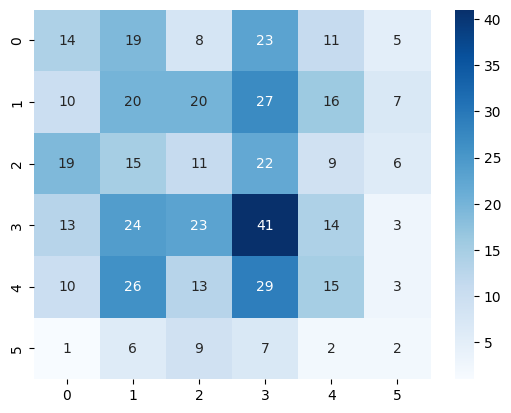

In [15]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

Y_pred = model.predict(val_gen)
y_pred = Y_pred.argmax(axis=1)
cm = confusion_matrix(val_gen.classes, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

print(classification_report(val_gen.classes, y_pred, target_names=val_gen.class_indices.keys()))


### Evaluate and Save Model

In [16]:
acc = model.evaluate(val_gen)[1]
print(f"Validation Accuracy: {acc:.2f}")

model.save('trashnet_mobilenetv2.h5')


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 152ms/step - accuracy: 0.7558 - loss: 0.7998


Validation Accuracy: 0.76


### Convert to TensorFlow Lite (Quantized)

In [17]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]  # full-int8 quantization
tflite_model = converter.convert()

with open('trashnet_model.tflite', 'wb') as f:
    f.write(tflite_model)


Saved artifact at '/tmp/tmpkegl5yoh'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='keras_tensor_951')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  139388063280656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139388063281808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139388063281616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139388063281040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139388063282384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139388063280464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139388063282000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139388063282192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139388063281232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139388063283344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1393880632

### Download Model to Your Laptop

In [19]:
from google.colab import files
files.download('trashnet_mobilenetv2.h5')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>